In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import string
import theano
import therapy
import importlib
import itertools

sns.set()
sns.set_style('whitegrid')
plt.ion()

# Functions and Classes

In [2]:
def compare(fitted_models):
    """
    Compare models on WAIC (and some other measures)

    In:
        fitted_models: iterable of FittedModel instances
        
    Out:
        DataFrame, indexed by model names, columns having comparison values
    """
    
    # variable needs to be Series instead of just list b/c 'pm.compare' returns dataframe which is sorted
    # by information criterion value. need to match model names to entries of that dataframe by index,
    # which indicates initial position of the model when given to this function
    # note: silly design by pymc3
    model_names = pd.Series([fm.name for fm in fitted_models])
    
    model_dict = {fm.model: fm.trace for fm in fitted_models}
    
    return (
        pm
        .compare(
            model_dict = model_dict,
            method = 'BB-pseudo-BMA'
        )
        .assign(model =  model_names)
        .set_index('model')
        .sort_values('WAIC')
    )

In [3]:
# Code 7.2

def create_rugged_log_gdp_model(dataset, return_dataframe=True):
    """
    model log_gdp as a linear function of ruggedness using data from `dataset`
    """
    with pm.Model() as model:
        sigma = pm.Uniform('sigma', 0, 10)
        bR = pm.Normal('bR', 0, 1)
        a = pm.Normal('a', 8, 100)
        mu = pm.Deterministic('mu', a + bR * dataset.rugged)
        log_gdp = pm.Normal('log_gdp', mu, sigma, observed=dataset.log_gdp)

        trace = pm.sample(1000, tune=1000, progressbar=False)
        
    if return_dataframe:
        trace = pm.trace_to_dataframe(trace)
        
    return model, trace

In [4]:
def attach_mu_predictions_to_data(xy_data, trace_df):
    """
    For source data and a trace of posterior samples: calculate sample mean and hpd boundaries,
    attach them to the original data into one joined dataframe.
    
    Assume that 'mu__n' column of samples belongs to n-th data point in dataframe.
    
    In:
        xy_data: dataframe
        trace_df: dataframe having columns with name pattern 'mu__x'
        
    Out:
        'xy_data' dataframe with new columns 'mu_means', 'mu_hpd_lower', and 'mu_hpd_upper'
    """
    
    mu_samples = trace_df.filter(like='mu__')
    mu_means = mu_samples.mean(axis=0)

    mu_hpd_lower, mu_hpd_upper = np.split(
        ary=pm.hpd(mu_samples.values, alpha=0.03),
        indices_or_sections=2,
        axis=1
    )

    return (
        xy_data
        .assign(
            mu_means = mu_means.values,
            mu_hpd_upper = mu_hpd_upper,
            mu_hpd_lower = mu_hpd_lower
        )
    )

In [5]:
def create_plot_scatter_with_predicted_means(xy_data, trace_df, x, y, ax = None, plot_y = True):
    """
    Make predictions from samples, attach them to original data and plot original data and
    predictions together
    
    In:
        xy_data: dataframe with columns 'x' and 'y'
        trace_df: dataframe with posterior samples
        x: string col name
        y: string col name
        ax: what axes to plot into
    
    Out:
        ax: axes with plot
    """
    
    # calculate sample summaries and attach to original data
    # sort by x for plotting line of predicted mu values
    d_with_preds = attach_mu_predictions_to_data(xy_data, trace_df).sort_values(x)

    if ax is None:
        ax = plt.axes()

    ax.plot(x, 'mu_means', 'g-', data=d_with_preds)
    ax.fill_between(x, 'mu_hpd_lower', 'mu_hpd_upper', color='g', alpha=.3, data=d_with_preds)
    
    if plot_y:
        ax.plot(x, y, 'ob', mew=1, fillstyle='none', alpha=.3, data=d_with_preds)
    
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    
    return ax

In [6]:
class FittedModel(object):
    """
    Container to hold pymc3 model together with its mcmc trace and theano shared variables for prediction
    """
    
    def __init__(self, model, trace, predictor_dict, name):
        """
        model: pymc3 model
        trace: pymc3 trace for model
        predictor_dict = {'predictor_n': theano_tensor_n}
        """
        self.model = model
        self.trace = trace
        
        if predictor_dict is None:
            self.predictor_dict = None
        else:
            self.predictor_dict = {
                predictor_name: {
                    'shared_variable': shared_variable,
                    'original_value': shared_variable.get_value()
                }
                for predictor_name, shared_variable in predictor_dict.items()
            }
        self.name = name
        
    def _repr_latex_(self):
        return self.model._repr_latex_()
    
    
    def _set_predictor_values(self, predictor_values):
        """
        Set values of shared theano tensors to given values
        
        In:
            predictor_values: DataFrame, column = predictor
        
        Out:
            None, only side effects
        """
        
        # set shared variables to passed values
        for predictor_name in predictor_values.columns:
            predictor_shared_variable = self.predictor_dict[predictor_name]['shared_variable']
            predictor_shared_variable.set_value(predictor_values[predictor_name].values)
        
        
    def _reset_predictor_values(self):
        """
        Revert all shared variables to original state
        
        In:
            none
            
        Out:
            None
        """

        for _,  pred_dict in self.predictor_dict.items():
            pred_dict['shared_variable'].set_value(pred_dict['original_value'])
    
    
    def sample_mu(self, predictor_values):
        """
        Generate samples of 'mu' variable based on 'predictor_values' (yes, this is basically
        the 'link' function, just as a method).
                
        In:
            predictor_values: DataFrame with column names matching this_model.predictor_dict.keys()

        Out:
            df with samples for means, one column per input data point
        """

        # set shared variables to passed values
        self._set_predictor_values(predictor_values)

        samples = pm.sample_ppc(
            trace=self.trace, 
            model=self.model, 
            vars=[self.model.mu],
            progressbar=False
        )

        # revert shared variables to original state
        # if skipped all future interactions with model will use predictor values passed for this
        # function call as a side effect. makes reasoning harder.
        # TODO: make this automatic, e.g. through modifying shared variables only in context
        self._reset_predictor_values()

        mu_samples = samples['mu']

        columns = ['mu__{}'.format(i) for i in range(mu_samples.shape[1])]

        return pd.DataFrame(data=mu_samples, columns=columns)
    
    def predict_mu(self, predictor_values):
        """
        Generate mean/hpd predictions for mu based on 'predictor_values'. Closest to model.predict()
        in sklearn
        
        In:
            predictor_values: DataFrame with column names matching this_model.predictor_dict.keys()

        Out:
            df with mean and hpd of estimated mus, each row matches one input row of predictor_values df
        """
        
        mu_samples = self.sample_mu(predictor_values)

        mu_means = mu_samples.mean(axis=0)

        mu_hpd_lower, mu_hpd_upper = np.split(
            ary=pm.hpd(mu_samples.values, alpha=0.03),
            indices_or_sections=2,
            axis=1
        )

        # 'squeeze()' necessary to remove empty 2nd axis, pandas complains otherwise
        return pd.DataFrame(
            {
                'mu_means': mu_means, 
                'mu_hpd_lower': mu_hpd_lower.squeeze(), 
                'mu_hpd_upper': mu_hpd_upper.squeeze()
            }
        )

In [7]:
def link(fitted_model, predictor_values):
    """
    Generate samples of 'mu' variable for 'fitted_model' based on 'predictor_values'

    In:
        fitted_model: FittedModel instance
        predictor_values: DataFrame with column names matching fitted_model.predictor_dict.keys()
        
    Out:
        df with samples for means, one column per input data point
    """

    return fitted_model.sample_mu(predictor_values)

In [8]:
def precis(fitted_model):
    """
    Take a fitted model, give summaries about posterior estimates
    
    In:
        fitted_model: instance of FittedModel
    
    Out:
        pandas df with posterior summaries
    """
    
    summary =  pm.summary(fitted_model.trace, alpha=.11)

    # filter out deterministic variables
    # recognized by the '__'  in the name
    return summary.loc[[ix for ix in summary.index if '__' not in ix]]

In [9]:
def extract_samples(fitted_model):
    """
    In:
        fitted_model: FittedModel instance
        
    Out:
        DataFrame with posterior samples of parameters
    """
    
    return pm.trace_to_dataframe(fitted_model.trace)

# 7 Interactions

Conditioning: data conditional on how we get our samples. Posterior distributions conditional on data. All inference conditional on the model. Every inference is conditional, but we might not realize it.

Lin model = way of seeing outcome as conditional on predictors of that case.

Lin model assumes each predictor has independent association w/ mean of outcome **how does this work if interpretation of coefficient is "amount information gained when learning about this variable, already knowing all others"? probably doesn't work. need more basic interpretation. maybe "coefficent = expected change in outcome mean for unit increase in predictor, while keeping other predictors constant". still linked somehow?**

Ex: assume that link between brain size and milk energy depends on what kind of primate we are looking at (ape, monkey, prosimian). Influence needs to be conditional on that. McElreath: Lin. model in previous chapters cannot capture this. **again seems to indicate that we cannot use interpretation of 'given all other factors, how much do we learn about milk energy by getting information about brain size'. because 'all other factors' would include 'kind of primate'. which is weird, because is this not what 'statistically controlling for' would imply? we put in the another predictor into the model and thus control for it. more questions, not more answers. need discussion.**

want to model: importance of predictor A depends on predictor B. need: interaction. simplest one: linear interaction. see below.

## 7.1. Building an interaction

In [11]:
# Code 7.1

d = pd.read_csv('./data/rugged.csv', sep=';').set_index('isocode')

# make log version of outcome
d = d.assign(log_gdp=np.log(d.rgdppc_2000))

# drop incomplete cases
dd = d.dropna(subset=['rgdppc_2000'])

# split countries into africa and not-africa
d_a1 = dd.query('cont_africa == 1')
d_a0 = dd.query('cont_africa == 0')

In [12]:
# african countries
m_7_1, trace_7_1 = create_rugged_log_gdp_model(d_a1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, sigma]


In [13]:
# non-african countries
m_7_2, trace_7_2 = create_rugged_log_gdp_model(d_a0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, sigma]


Text(0.5, 1.0, 'Non-African countries')

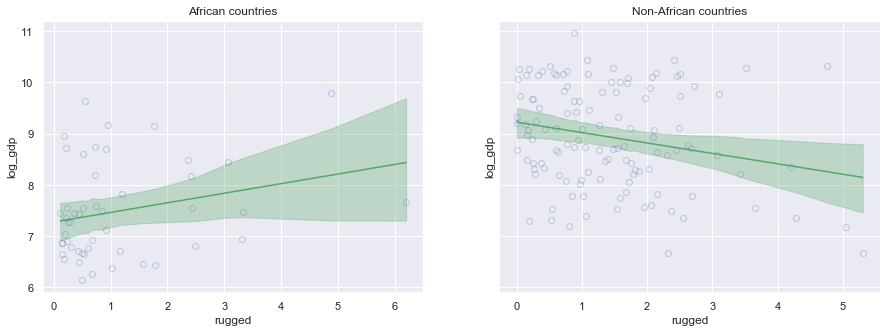

In [14]:
x = 'rugged'
y = 'log_gdp'

fig, axes_array = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)

ax = create_plot_scatter_with_predicted_means(d_a1, trace_7_1, x, y, axes_array[0])
ax.set_title('African countries')

ax = create_plot_scatter_with_predicted_means(d_a0, trace_7_2, x, y, axes_array[1])
ax.set_title('Non-African countries')

Slope different, but bad idea to split data into two frames like this because:

* now assumes variance (sigma) is different between african and non-african countries
* can't make statements about predictive power/uncertainty of 'is_african' variable used to split data
* can't use information criteria to compare models b/c fitted on different data
* can't use information from non-african countries for african countries/vice versa, which is done in multilevel models

Instead, create one model that allows different slope based on predictor values

### 7.1.1. adding a dummy variable doesn't work

In [15]:
# Code 7.3

m, t = create_rugged_log_gdp_model(dd, return_dataframe=False)

fit_m_7_3 = FittedModel(m, t, None, 'm_7_3')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, sigma]


In [23]:
# Code 7.4

dataset = dd

with pm.Model() as model:
    
    sigma = pm.Uniform('sigma', 0, 10)
    
    bR = pm.Normal('bR', 0, 1)
    bA = pm.Normal('bA', 0, 1)
    
    a = pm.Normal('a', 8, 100)
    
    rugged = theano.shared(dataset.rugged.values)
    cont_africa = theano.shared(dataset.cont_africa.values)
    
    mu = pm.Deterministic('mu', a + bR * rugged + bA * cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=dataset.log_gdp)

    trace = pm.sample(1000, tune=1000, progressbar=False)


# object for easier bookkeeping
fit_m_7_4 = FittedModel(
    model = model,
    trace = trace,
    predictor_dict = {
        'rugged': rugged,
        'cont_africa': cont_africa
    },
    name = 'm_7_4'
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, bR, sigma]


In [24]:
# Code 7.5
compare(
    [
        fit_m_7_3,
        fit_m_7_4
    ]
)

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m_7_4,476.13,4.19,0,1,14.9,0,1
m_7_3,539.29,2.51,63.16,0,13.32,14.55,0


Text(0.5, 1.0, 'African countries')

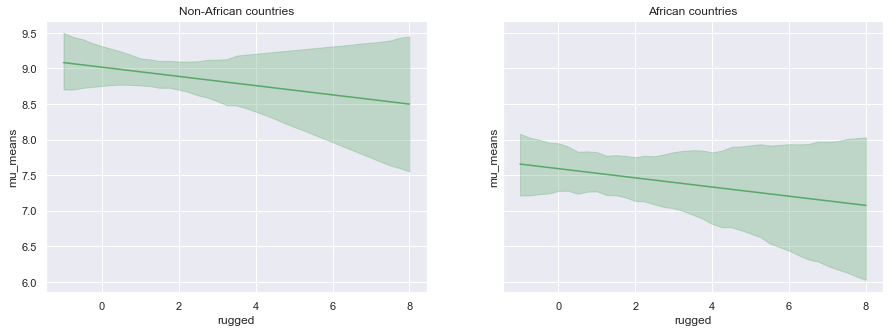

In [25]:
# Code 7.6

# range of x-values
rugged_values = np.arange(-1, 8.25, 0.25)

# dataframes with predictor values
d_not_africa = pd.DataFrame({'rugged': rugged_values, 'cont_africa': 0})
d_africa = pd.DataFrame({'rugged': rugged_values, 'cont_africa': 1})

# create posterior samples of mu for predictor values
mu_not_africa = link(fit_m_7_4, d_not_africa)
mu_africa = link(fit_m_7_4, d_africa)

# x/y variable names
x = 'rugged'
y = 'mu_means'

# plots
fig, axes_array = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)

ax = create_plot_scatter_with_predicted_means(d_not_africa, mu_not_africa, x, y, axes_array[0], plot_y=False)
ax.set_title('Non-African countries')

ax = create_plot_scatter_with_predicted_means(d_africa, mu_africa, x, y, axes_array[1], plot_y=False)
ax.set_title('African countries')

No difference whatsoever in slope, perfectly parallel, just shifted. Can't change slope by including dummy variable. Model is only better in terms of WAIC b/c it allows model to capture fact that African nations on average have lower GDP

### 7.1.2. Adding a linear interaction does work

In [26]:
# Code 7.7

dataset = dd

with pm.Model() as model:
    
    sigma = pm.Uniform('sigma', 0, 10)
    
    bR = pm.Normal('bR', 0, 1)
    bA = pm.Normal('bA', 0, 1)
    bAR = pm.Normal('bAR', 0, 1)
    
    a = pm.Normal('a', 8, 100)
    
    rugged = theano.shared(dataset.rugged.values)
    cont_africa = theano.shared(dataset.cont_africa.values)
    
    gamma = pm.Deterministic('gamma', bR + bAR * cont_africa)
    mu = pm.Deterministic('mu', a + gamma * rugged + bA * cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=dataset.log_gdp)

    trace = pm.sample(1000, tune=1000, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bAR, bA, bR, sigma]


In [27]:
fit_m_7_5 = FittedModel(model, trace, {'rugged': rugged, 'cont_africa': cont_africa}, 'm_7_5')

In [28]:
# Code 7.8

compare(
    [
        fit_m_7_3,
        fit_m_7_4,
        fit_m_7_5
    ]
)

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m_7_5,469.49,5.04,0,0.86,13.63,0,1
m_7_4,476.13,4.19,6.64,0.14,13.74,5.73,1
m_7_3,539.29,2.51,69.8,0,12.48,14.56,0


**note** WAIC similar to book. weights diverge, m_7_5 has 97% of weight in book instead of 83% here

unclear what information criteria mean in this context. McElreath: "reasonable people can disagree on this".

Author thinks IC still useful, even if we don't have train/test case, i.e. we are not going to draw more samples from process that creates African/Non-African nations and predict for those. However, WAIC measures flexiblity of model in general, can still warn about overfitting.

**overthinking: conventional form of interaction** interaction model can also be written by multiplying predictors, yielding this:

$$
\mu_i = \alpha + \beta_R R_i + \beta_{AR} R_i*A_i + \beta_A A_i
$$

equivalent to form earlier in this chapter, just have to multiply out the $\gamma_i$ factor back into the original term.

Can also use this form to fit model:

In [29]:
# Code 7.9

dataset = dd

with pm.Model() as model:
    
    sigma = pm.Uniform('sigma', 0, 10)
    
    bR = pm.Normal('bR', 0, 1)
    bA = pm.Normal('bA', 0, 1)
    bAR = pm.Normal('bAR', 0, 1)
    
    a = pm.Normal('a', 8, 100)
    
    rugged = theano.shared(dataset.rugged.values)
    cont_africa = theano.shared(dataset.cont_africa.values)
    
    mu = pm.Deterministic('mu', a + bR * rugged + bAR * rugged * cont_africa + bA * cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=dataset.log_gdp)

    trace = pm.sample(1000, tune=1000, progressbar=False)

fit_m_7_5_b = FittedModel(model, trace, {'rugged': rugged, 'cont_africa': cont_africa}, 'm_7_5_b')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bAR, bA, bR, sigma]


### 7.1.3. Plotting interactions

In [30]:
# Code 7.10

# range of x-values
rugged_values = np.arange(-1, 8.25, 0.25)

# dataframes with predictor values
d_not_africa = pd.DataFrame({'rugged': rugged_values, 'cont_africa': 0})
d_africa = pd.DataFrame({'rugged': rugged_values, 'cont_africa': 1})

# create mu samples for posterior estimates based on above data
mu_not_africa = fit_m_7_5.sample_mu(d_not_africa)
mu_africa = fit_m_7_5.sample_mu(d_africa)

Text(0.5, 1.0, 'African countries')

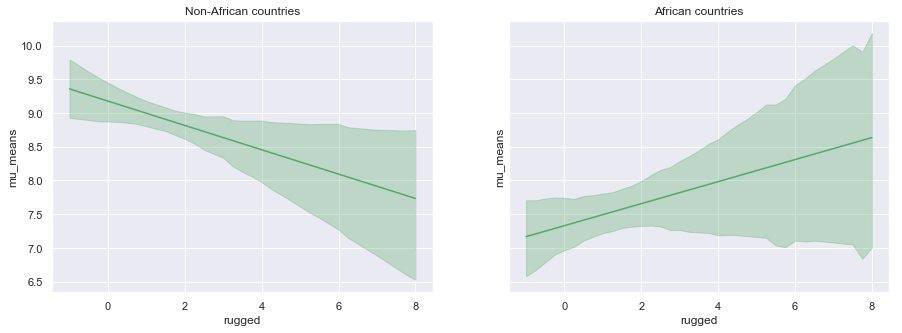

In [31]:
# Code 7.11

# x/y variable names
x = 'rugged'
y = 'mu_means'

# plots
fig, axes_array = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)

ax = create_plot_scatter_with_predicted_means(d_not_africa, mu_not_africa, x, y, axes_array[0], plot_y=False)
ax.set_title('Non-African countries')

ax = create_plot_scatter_with_predicted_means(d_africa, mu_africa, x, y, axes_array[1], plot_y=False)
ax.set_title('African countries')

In [32]:
pm.trace_to_dataframe(fit_m_7_5.trace).mean().filter(like='b')

bR    -0.178205
bA    -1.831986
bAR    0.338924
dtype: float64

### 7.1.4. Interpreting an interaction estimate

Effect in non-interaction model does not mean the same thing as effect of same predictor in interaction model. Generally intepretation is hard, plots preferred to tables of number. Difficulties:

#### 7.1.4.1. Parameters change meaning

Lin. regression w/o interactions: coefficient = how much average outcome $\mu$ changes when predictor changes by one unit.

All parameters have independent influence on outcome, meaning can interpet coefficients independently. Each slope parameter = measure of predictor variable's influence.

Not true anymore for interaction models. $\gamma$ depends on bR, bAR and Ai, need to know all of these to compute that slope.

In [33]:
# Code 7.12

precis(fit_m_7_5)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
bR,-0.178205,0.078716,0.002509,-0.311894,-0.059494,844.066221,1.000033
bA,-1.831986,0.222989,0.007281,-2.200644,-1.490212,856.991382,1.000706
bAR,0.338924,0.132539,0.004404,0.122334,0.536812,870.077040,1.000812
a,9.174228,0.142193,0.004297,8.944959,9.397163,890.947832,0.999707
sigma,0.951865,0.054751,0.001409,0.869194,1.042795,1511.251139,0.999528


#### 7.1.4.2. Incorporating uncertainty

$\gamma$ has distribution because it depends on parameters, which in turn have distributions. **anything calculated using parameters has a distribution**. "one of the most important concepts on Bayesian model fitting"

In [34]:
# Code 7.13

post = extract_samples(fit_m_7_5)
gamma = pd.DataFrame(
    data=[
        post.bR + post.bAR * 1, 
        post.bR + post.bAR * 0
    ], 
    index=['africa', 'not_africa']
).T

In [35]:
# Code 7.14

gamma.mean()

africa        0.160719
not_africa   -0.178205
dtype: float64

Text(0, 0.5, 'density')

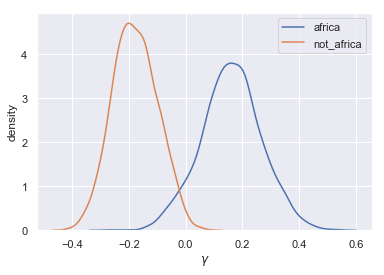

In [36]:
# Code 7.15

sns.kdeplot(gamma.africa)
sns.kdeplot(gamma.not_africa)

ax = plt.gca()
ax.set_xlabel('$\gamma$')
ax.set_ylabel('density')

In [37]:
# Code 7.16

# probability of slope in africa being smaller than slope outside of africa
(gamma.africa < gamma.not_africa).mean() * 100

0.65

Note: 0.4% much smaller than visual overlap in figur above. Reason: figure shows marginal of each case "like silhouettes of each distribution". Not actually distribution of difference. "If you care about the difference, you must compute the disribution of difference directly". Same mechanism why overlap of confidence intervals can't be used as visual test of significance for parameter estimates

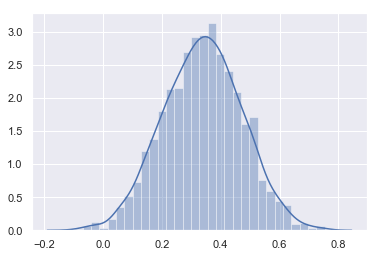

In [38]:
# So what is the distribution of differences?

sns.distplot(gamma.africa - gamma.not_africa)

Rethinking: More on the meaning of posterior probability. 0.4% is *not* probability of observing an event. Don't expect 0.36% of African nations to have worse impact of ruggedness on log gdp than country outside of Africa. 

Actual meaning: relative plausibilty for question asked given this model and these data. Model assigns very low plausibilty for $\gamma$ being lower in Africa than outside. Of known possible states of the world (**question: possible states of the world = coefficient values?**) only 0.4% are consistent with that being the case and with the data.

Model is highly sceptical of that being the case, but we should also keep being sceptical of the model

## 7.2. Symmetry of the linear interaction

### 7.2.1. Buridan's interaction

When expanding interaction term to conventional form it's obvious to see that it's symmetrical between the two predictors it involves:

$$
\mu_i = \alpha + \beta_R R_i + \beta_{AR} R_i*A_i + \beta_A A_i
$$

it involves R_i and A_i in the same way.

Translated: how ruggedness impacts log_gdp depens on being in Africa or not. impact of being in Africa or not on log_gdp depends on ruggedness. Symmetrical in model.

No difference to model, but humans tend to give causal interpretation. Easier to think about changing one predictor than the other. Easier to think about changing ruggedness thant whether a nation is in Africa

### 7.2.2. Africa depends on ruggedness

Text(38.23937986111112, 0.5, 'log GDP year 2000')

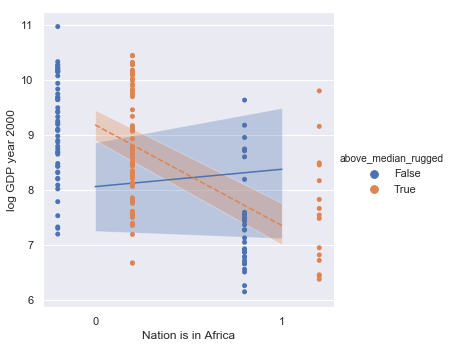

In [85]:
# Code 7.17

# get minimum and maximum rugged values
q_rugged = (dd.rugged.min(), dd.rugged.max())

# compute lines and confidence intervals
mu_ruggedlo_summary = fit_m_7_5.predict_mu(pd.DataFrame({'rugged': q_rugged[0], 'cont_africa': [0, 1]}))
mu_ruggedhi_summary = fit_m_7_5.predict_mu(pd.DataFrame({'rugged': q_rugged[1], 'cont_africa': [0, 1]}))

# plot it all, splitting points at media
med_r = dd.rugged.median()

dd = dd.assign(above_median_rugged = dd.rugged > med_r)

sns.catplot(
    data=dd, 
    x='cont_africa', 
    y='log_gdp', 
    hue='above_median_rugged', 
    dodge=True, 
    jitter=0
)

ax = plt.gca()

for mu_data, linestyle in [(mu_ruggedhi_summary, '-'), (mu_ruggedlo_summary, '--')]:
    ax.plot(
        [0, 1], 
        mu_data.mu_means,
        linestyle
    )
    
    ax.fill_between(
        x=[0, 1], 
        y1=mu_data.mu_hpd_lower,
        y2=mu_data.mu_hpd_upper,
        alpha=.3
    )

ax.set_xlabel('Nation is in Africa')
ax.set_ylabel('log GDP year 2000')

For low-ruggedness country moving from not-Africa to Africa reduces log GDP by 2 points on average. For very rugged country the same move nearly has no effect.

Obviously nonsensical interpretation given real-world knowledge. However, not given by model or data. For these data and this model, both of these are true at the same time:
* influence of ruggedness depends on continent
* influence of continent depends on ruggendess

However, additional thing learnt by this 'transposed' view: African nations nearly always worse off than non-African ones.

## 7.3 Continuous interactions
Main point: interaction effects hard to interpret. Nearly impossible just by looking at numbers. Even more so for interactions between continuous variables.

For cat variable: different slope per unique category. For continuous var: slope gradually changes. Even harder to grasp.

Centering vars can help both in interpretation and model fitting.

But, central message: always plot posterior predictions (counterfactual or real) to understand model fit.

### 7.3.1. The data
Tuplip bloom sizes

In [98]:
# Code 7.18

d = (
    pd
    .read_csv('./data/tulips.csv', sep=';')
)

d.head()

,bed,water,shade,blooms
0,a,1,1,0.00
1,a,1,2,0.00
2,a,1,3,111.04
3,a,2,1,183.47
4,a,2,2,59.16


task: predict 'blooms' from other variables. likely, more water and less shade, i.e. more light, will both help. but also connected: without light, no additional will be helpful

### 7.3.2. The un-centered models

quote: 'So this means that priors that look very flat may not actually be, because “flat” is always relative to the likelihood.' **discuss**

In [113]:
# Code 7.19

# create and fit model without interaction
shared = {
    'water': theano.shared(d.water.values, 'water'),
    'shade': theano.shared(d.shade.values, 'shade')
}

with pm.Model() as m:
    sigma = pm.Uniform('sigma', 0, 100)
    bS = pm.Normal('bS', 0, 100)
    bW = pm.Normal('bW', 0, 100)
    a = pm.Normal('a', 0, 100)
    mu = pm.Deterministic('mu', a + bW * shared['water'] + bS * shared['shade'])
    blooms = pm.Normal('blooms', mu, sigma, observed=d.blooms)

m_7_6 = therapy.Model(m, shared, 'm_7_6')

m_7_6.fit(d)

pm.find_MAP(model=m_7_6.model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bW, bS, sigma]
logp = -175.26, ||grad|| = 0.0011502: 100%|██████████| 24/24 [00:00<00:00, 1416.44it/s]  


{'sigma_interval__': array(19.99194662),
 'bS': array(-34.77920715),
 'bW': array(76.44616379),
 'a': array(44.02992948),
 'sigma': array(100.),
 'mu': array([ 85.69688612,  50.91767897,  16.13847183, 162.14304991,
        127.36384277,  92.58463562, 238.58921371, 203.81000656,
        169.03079941,  85.69688612,  50.91767897,  16.13847183,
        162.14304991, 127.36384277,  92.58463562, 238.58921371,
        203.81000656, 169.03079941,  85.69688612,  50.91767897,
         16.13847183, 162.14304991, 127.36384277,  92.58463562,
        238.58921371, 203.81000656, 169.03079941])}

In [114]:
# create and fit model interaction
shared = {
    'water': theano.shared(d.water.values, 'water'),
    'shade': theano.shared(d.shade.values, 'shade')
}

with pm.Model() as m:
    sigma = pm.Uniform('sigma', 0, 100)
    bS = pm.Normal('bS', 0, 100)
    bW = pm.Normal('bW', 0, 100)
    bWS = pm.Normal('bWS', 0, 100)
    a = pm.Normal('a', 0, 100)
    mu = pm.Deterministic('mu', a + bW * shared['water'] + bS * shared['shade'] + bWS * shared['water'] * shared['shade'])
    blooms = pm.Normal('blooms', mu, sigma, observed=d.blooms)

m_7_7 = therapy.Model(m, shared, 'm_7_7')

m_7_7.fit(d)

pm.find_MAP(model=m_7_7.model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bWS, bW, bS, sigma]
The acceptance probability does not match the target. It is 0.8877635449867929, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
logp = -170.17, ||grad|| = 0.012971: 100%|██████████| 54/54 [00:00<00:00, 905.68it/s]     


{'sigma_interval__': array(-0.15013976),
 'bS': array(34.9836048),
 'bW': array(151.00906588),
 'bWS': array(-39.50317218),
 'a': array(-84.31089711),
 'sigma': array(46.253541),
 'mu': array([ 62.17860138,  57.659034  ,  53.13946661, 173.68449507,
        129.66175551,  85.63901594, 285.19038877, 201.66447702,
        118.13856527,  62.17860138,  57.659034  ,  53.13946661,
        173.68449507, 129.66175551,  85.63901594, 285.19038877,
        201.66447702, 118.13856527,  62.17860138,  57.659034  ,
         53.13946661, 173.68449507, 129.66175551,  85.63901594,
        285.19038877, 201.66447702, 118.13856527])}

Warning messages above, such as 'The number of effective samples is smaller than 25% for some parameters.' expected. Optimization algo has trouble finding good solutions. Can be fixed by:
* use another optimization method
* increase max search iterations
* rescale data to make search easier. Fundamental issue: scale of 'bloom'.

Trying first two solutions:

In [115]:
# Code 7.20

# took code from here: https://github.com/pymc-devs/resources/blob/master/Rethinking/Chp_07.ipynb

from scipy import optimize
map_7_6 = pm.find_MAP(model=m_7_6.model, method='Powell')
map_7_6

  0%|          | 0/5000 [00:00<?, ?it/s]/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/scipy/optimize/_minimize.py:501: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
logp = -169.34, ||grad|| = 0.035313: 100%|██████████| 384/384 [00:00<00:00, 1166.03it/s]  


{'sigma_interval__': array(0.29394305),
 'bS': array(-38.97889713),
 'bW': array(76.30032904),
 'a': array(53.68225463),
 'sigma': array(57.29611814),
 'mu': array([ 91.00368654,  52.02478941,  13.04589228, 167.30401557,
        128.32511844,  89.34622131, 243.60434461, 204.62544748,
        165.64655035,  91.00368654,  52.02478941,  13.04589228,
        167.30401557, 128.32511844,  89.34622131, 243.60434461,
        204.62544748, 165.64655035,  91.00368654,  52.02478941,
         13.04589228, 167.30401557, 128.32511844,  89.34622131,
        243.60434461, 204.62544748, 165.64655035])}

In [116]:
map_7_7 = pm.find_MAP(model=m_7_7.model, method='Powell')
map_7_7

logp = -170.17, ||grad|| = 0.0014459: 100%|██████████| 824/824 [00:00<00:00, 1106.79it/s] 


{'sigma_interval__': array(-0.15002091),
 'bS': array(34.97300695),
 'bW': array(150.99792141),
 'bWS': array(-39.49642547),
 'a': array(-84.29365942),
 'sigma': array(46.25649567),
 'mu': array([ 62.18084347,  57.65742495,  53.13400643, 173.68233941,
        129.66249541,  85.64265142, 285.18383535, 201.66756587,
        118.1512964 ,  62.18084347,  57.65742495,  53.13400643,
        173.68233941, 129.66249541,  85.64265142, 285.18383535,
        201.66756587, 118.1512964 ,  62.18084347,  57.65742495,
         53.13400643, 173.68233941, 129.66249541,  85.64265142,
        285.18383535, 201.66756587, 118.1512964 ])}

In [163]:
# Code 7.21
therapy.coeftab([m_7_6, m_7_7]).sort_index()

,m_7_6,m_7_7
a,53.126661,-71.584954
bS,-38.361310,29.788829
bW,76.012188,144.885397
bWS,NaN,-37.028425
sigma,63.092791,52.925239


Interpretation hard. 
* $a$ varies a lot between models, but actually has no examples in data - water and shade are never 0.
* posterior of 7_6 implies more shade is worse, more water is good
* but posterior of 7_7 implies more shade is actually better
* direct comparison of both models by waic implies 7_7 is a lot better model (see below) - so is shade good for bloom?
* mitigated by negative interaction term - but how does that actually reflect in predictions?

In [166]:
# Code 7.22
therapy.compare([m_7_6, m_7_7])

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m_7_7,294.25,4.21,0,0.96,6.95,0,1
m_7_6,303.52,3.66,9.27,0.04,6.82,3.84,1


Generally, not safe to interpret interactions without plotting them. Highly encouraged to plot model predictions

For now: try centering to improve estimates

**Rethinking: Fighting with your robot.** Issues in fitting such as above annoying but realistic. In general: **how you fit the model is part of the model**. Best approach: get used to troubleshooting.

### 7.3.3. Center re-estimate

In [168]:
# Code 7.23
d = (
    d
    .assign(
        shade_c = d.shade - d.shade.mean(),
        water_c = d.water - d.water.mean()
    )
)

In [214]:
importlib.reload(therapy)

<module 'therapy' from '/Users/niweber/rethinking_statistics_code/therapy.py'>

In [216]:
# Code 7.24

models = list()

for interact, name in zip([False, True], ['m_7_8', 'm_7_9']):
    print('building and fitting model '+name)
    
    # create shared variables from centered values
    shared = {
        'water_c': theano.shared(d.water_c.values, 'water_c'),
        'shade_c': theano.shared(d.shade_c.values, 'shade_c')
    }

    # model definition
    with pm.Model() as m:
        sigma = pm.Uniform('sigma', 0, 100)
        bS = pm.Normal('bS', 0, 100)
        bW = pm.Normal('bW', 0, 100)
        a = pm.Normal('a', 0, 100)
        if interact:
            bWS = pm.Normal('bWS', 0, 100)
            mu = pm.Deterministic('mu', a + bW * shared['water_c'] + bS * shared['shade_c'] + bWS * shared['water_c'] * shared['shade_c'])
        else:
            mu = pm.Deterministic('mu', a + bW * shared['water_c'] + bS * shared['shade_c'])
        blooms = pm.Normal('blooms', mu, sigma, observed=d.blooms)

    # fit model with useful starting values
    t_model = therapy.Model(m, shared, name)
    t_model.fit(
        d, 
        progressbar=False,
        draw=1000,
        tune=1000,
        start={
            'a': d.blooms.mean(),
            'bW': 0,
            'bS': 0,
            'bWS': 0,
            'sigma': d.blooms.std()
        }
    )
    
    # add fitted model to list
    models.append(t_model)

building and fitting model m_7_8


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bW, bS, sigma]
The acceptance probability does not match the target. It is 0.92596120764587, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.895972019102794, but should be close to 0.8. Try to increase the number of tuning steps.


building and fitting model m_7_9


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bWS, a, bW, bS, sigma]


In [217]:
m_7_8, m_7_9 = models
therapy.coeftab(models)

,m_7_8,m_7_9
bS,-40.940415,-40.693868
bW,73.562139,74.573332
a,127.016592,127.304406
sigma,64.223340,51.882291
bWS,NaN,-51.423707


Observations: 
* effects of water, shade now the same across both models
* however, interaction has not changed
* how come?

#### 7.3.3.1. estimation worked better
Search failed b/c MAP values far away from starting values, hard to find. After centering, MAP value for $\alpha$ is just mean of $bloom$, easy to find, can even be initialized as such.

#### 7.3.3.2. Estimates changed less across models
How come effects changed direction between centered and uncentered versions of models? For uncentered: interaction term always has effect, as $water$ and $shade$ are never 0, even for average flower. For uncentered interaction model, prediction at average is:

In [248]:
# Code 7.25
k = therapy.coef(m_7_7)
k.a + k.bS * 2 + k.bW * 2 + k.bWS * 2 * 2

129.64979645269793

And, "by no coincidence at all" we get the same result by plugging in the mean values of the centered dataset into the equation of the interaction model trained on that dataset:

In [249]:
# Code 7.26
k = therapy.coef(m_7_9)
k.a + k.bS * 0 + k.bW * 0 + k.bWS * 0 * 0

127.30440596656615

$\alpha$ actually meaningful after centering, becomes grand mean of outcome. Thus: useful to center for this alone already

In [254]:
# Code 7.27
therapy.precis(m_7_9).sort_index()

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,127.304406,10.701801,0.351431,110.577104,143.386037,905.735156,1.002962
bS,-40.693868,11.488422,0.382605,-60.228606,-23.705060,893.385164,0.999075
bW,74.573332,12.169239,0.327560,57.325954,95.809304,1262.985320,0.999168
bWS,-51.423707,14.741342,0.508098,-74.857526,-28.695366,970.827380,0.999000
sigma,51.882291,8.232949,0.322458,38.957105,63.444700,633.863144,1.001007


Read:

* $\alpha$: expected value of $blooms$ when $water$ and $shade$ are at avg values. Avg values are 0 b/c of centering
* $\beta_W$: expcted change in $blooms$ when increasing $water$ by one unit, while $shade$ is fixed at avg value. Does not say anything about expected change for other value sof $shade$. Here: more water, bigger bloom
* $\beta_S$: expected change in $blooms$ for increase of $shade$ by one unit, while $water$ fixed at average of 0. No informationa about change for other $water$ values. Here: more shade, smaller bloom
* $\beta_{WS}$: first: change of influence of $water$ on $blooms$ when increasing $shade$ by one unit. second: expected change in influence of $shade$ on $blooms$ when increasing $water$ by one unit

Why is $bWS$ negative? B/c $water$ and $shade$ have opposite effect on $blooms$, but make each other more important. Hard to read from raw value '-51'. Need to plot to understand!

### 7.3.4. Plotting implied predictions

Plotting necessary to understand model.

Previously, could hold other var constant at any value, slope would not change. Not possible anymore w/ interactions. Thus: make multiple plots for multiple values of other var to understand model behavior.

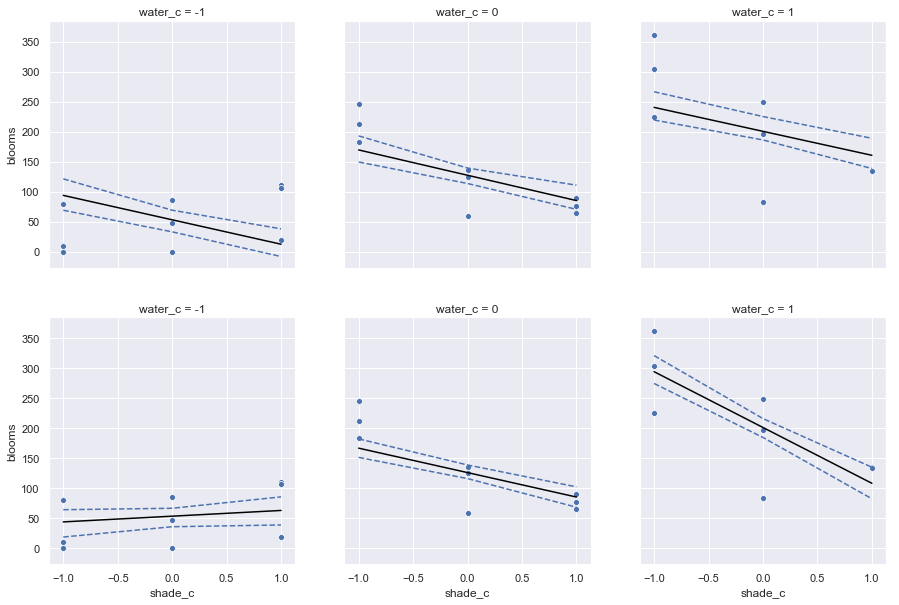

In [340]:
# Code 7.28

models = [m_7_8, m_7_9]
water_c_vals = [-1 , 0, 1]
combinations = itertools.product(models, water_c_vals)

fig, ax_array = plt.subplots(len(models), len(water_c_vals), sharex=True, sharey=True, figsize=(15, 10))

for (model, water_c), ax in zip(combinations, ax_array.ravel()):
    sns.scatterplot(x='shade_c', y='blooms', data=d[d.water_c == water_c], ax=ax)

    X = pd.DataFrame({'water_c': water_c, 'shade_c': [-1, 0, 1]})
    preds = model.predict(X, [model.model.mu])
    Xy = X.join(preds)
    
    # how could i do this with seaborn?
    ax.plot('shade_c', 'mu_mean', 'black', data=Xy)
    ax.plot('shade_c', 'mu_hpd_lower', 'b--', data=Xy)
    ax.plot('shade_c', 'mu_hpd_upper', 'b--', data=Xy)

    ax.set_title('water_c = {}'.format(water_c))

Observation: w/o interaction: same slope, shifted. W/ interaction: impact of shade depends on water level. More water = more negative impact of more shade. Also, symmetrically, but not plotted: more shade = more positie effect of more water.

Interpretation: water and shade both important for bloom. Need both light and water to grow, if one is missing other does not have a lot of effect

## 7.4. Interactions in design formulas
How to translate interactions into design formulas

In [342]:
# Code 7.29

# this formula and the following design formulae are taken from here:
# https://github.com/pymc-devs/resources/blob/master/Rethinking/Chp_07.ipynb
m_7_x = smf.ols('blooms ~ water_c + shade_c + water_c * shade_c', data=d)

In [343]:
# Code 7.30

m_7_x = smf.ols('blooms ~ water_c * shade_c', data=d)

In [345]:
# Code 7.31

m_7_x = smf.ols('blooms ~ shade_c + water_c * shade_c - water_c', data=d)

In [346]:
# Code 7.32

m_7_x = smf.ols('blooms ~ bed * water_c * shade_c', data=d)

In [347]:
# Code 7.33

In [360]:
# statsmodels uses patsy internally to parse these formulae
# adapted from https://github.com/pymc-devs/resources/blob/master/Rethinking/Chp_07.ipynb which uses an undefined variable here
import patsy
x, y, z = 1, 1, 1
d_matrix = patsy.dmatrix('~ x * y * z')
d_matrix.design_info.column_names

['Intercept', 'x', 'y', 'x:y', 'z', 'x:z', 'y:z', 'x:y:z']

## 7.5. Summary

Interactions allow influence of one predictor on outcome to vary depending on other predictor's values, and vice versa. This makes them difficult to interpret. Plotting predictions always recommended. Triptych plot useful instrument for this.

## 7.6. Practice

**Easy**

### 7E1.

* 1: dough rise ~ yeast. other: sugar, water, acidity, temperature
* 2: income ~ education. other: family wealth, family education, region, iq, height
* 3: car works ~ gasoline. other: battery charge, oil level, every bit in mechanical machinery chain of generating and transferring force

### 7E2.

* 1: Interaction. Heat and moisture both contribute. But without very high heat more moisture likely won't help (unless you'll be boiling the onions instead of caramelizing them, but that is not the goal)
* 2: Probably no interaction? I guess that for more cylinders an upgrade to the fuel injector will help as much as it would for fewer cylinders. But I don't know. And that does not cover the case of no cylinders/fuel injectors, in which the car does not go at all regardless of the other parts. So there is an interaction in this extreme but unrealistic case
* 3: Interaction. Your political beliefs depend on your parents. However, that influence diminishes if the influence of your friends increases.
* 4: Unsure. Probably interaction? From the way it is phrased it seems like you either only are social, or have manipulative appendages (excellent phrase). Which could be read as: intelligence increases with increasing social behavior, and with more manipulative appendages. But if either of those is already there, the other one won't have as much of an impact. However, humans seem to have both and have the highest intelligence we know about, so maybe effects are independent? Also questionable if causality just works this way around.

### 7E3.

1: time-series model
$$caramel_t = heat_t + moisture_t + heat_t * moisture_t + caramel_{t-1}$$

2: 
$$max\_speed = cylinder\_count + fuel\_injector\_effectivity$$

3:
$$political\_beliefs = political\_believes\_parents + political\_believes\_friends + political\_believes\_parents * political\_believes\_friends$$

4:
$$intelligence = socialness + manipulative\_appendages + socialness * manipulative\_appendages$$

**Medium**

### 7M1.

If none of the tulips bloom at all in hot temperatures that means that in a hot environment water and shade do not matter. There should be an interaction between water, shade, and temperature that sets the coefficients for water and shade to zero if temperature is hot.

### 7M2.

In this equation I'd like the effects of water and shade to be 0 if temperature is hot. I'd also like to cancel out the intercept in this case to ensure that the final result is 0, or have the intercept be 0 from the start. Let's encode temperature as follows: cold = 0, hot = 1. Then:

$$\mu = \alpha + \beta_T \text{temperature}$$

I expect this regression to end up such that $\alpha$ becomes the mean of cold bloom sizes, and $\beta_T$ to become $-1 * \alpha$. As such, when temperature = 1 they cancel out and the equation yields zero.

If wanting to also consider other variables:

$$\mu = \alpha + \beta_S * \text{shade} + \beta_W * \text{water} + \beta_T \text{temperature}$$

But this already becomes difficult. It is not enough to have $\beta_T = \beta_S$ for temperature to cancel out shade. Shade might have value 2, at which point $\beta_S * \text{shade}$ will overpower $\beta_T$. Thus we'll need interactions:

$$\mu = \alpha + \beta_S * \text{shade} + \beta_W * \text{water} + \beta_T \text{temperature} + beta_{ST} \text{temperature} * \text{shade} + \beta_T \text{temperature} + beta_{SW} \text{temperature} * \text{water}$$

Now through the interaction temperature can 'switch off' the influence of shade and water, and the individual effect of temperature can cancel out $\alpha$.

But what if we also want to have the interaction between shade and water in the model? My guess is that then the threeway interaction between shade, water, and temperature can be used to control this. As in, this interaction could then be read as a higher level interaction: 'the effect of the interaction of shade and water depends on the value of temperature'. However, I am not sure if threeway interactions actually work that way and can be interpreted like this.

**discuss and/or try to disentangle by explicitly writing down possible equation and/or fitting model on simulated data**

### 7M3.

$$
raven\_population = raven\_predators + food\_competition + autonomous\_food + wolf\_food + wolf\_population + wolf\_food * wolf\_population
$$

raven population is impacted by predators, competitionf for food, and general food availability. in particular, some foods can be consumed by ravens themselves (autonomous_food), e.g. insects, but for larger game cooperation with wolves is needed (wolf_food).

this is captured by the interaction of the wolf_food and wolf_population. I expect the effect of wolf_food on raven_population to change depending on wolf_population.

**Hard**

### 7H1.

In [375]:
# load fresh dataframe
d_tulips = (
    pd
    .read_csv('./data/tulips.csv', sep=';')
    .assign(
        shade_c = lambda x: x.shade - x.shade.mean(),
        water_c = lambda x: x.water - x.water.mean(),
    )
)

# create dummy columns for 'bed' categorical variable and join with data
dummies = pd.get_dummies(d_tulips.bed, prefix='bed', drop_first=True)
d_tulips = d_tulips.join(dummies)

d_tulips.head()

,bed,water,shade,blooms,shade_c,water_c,bed_b,bed_c
0,a,1,1,0.00,-1.0,-1.0,0,0
1,a,1,2,0.00,0.0,-1.0,0,0
2,a,1,3,111.04,1.0,-1.0,0,0
3,a,2,1,183.47,-1.0,0.0,0,0
4,a,2,2,59.16,0.0,0.0,0,0


In [379]:
# create shared variables from centered values
name = 'm_7_h1'
data = d_tulips

shared = {
    'water_c': theano.shared(data.water_c.values, 'water_c'),
    'shade_c': theano.shared(data.shade_c.values, 'shade_c'),
    'bed_b': theano.shared(data.bed_b.values, 'bed_b'),
    'bed_c': theano.shared(data.bed_c.values, 'bed_c'),
}

# model definition
with pm.Model() as m:
    sigma = pm.Uniform('sigma', 0, 100)
    bS = pm.Normal('bS', 0, 100)
    bW = pm.Normal('bW', 0, 100)
    bWS = pm.Normal('bWS', 0, 100)
    bBb = pm.Normal('bBb', 0, 100)
    bBc = pm.Normal('bBc', 0, 100)
    a = pm.Normal('a', 0, 100)
    mu = pm.Deterministic(
        'mu', 
        a + bW * shared['water_c'] + bS * shared['shade_c'] + bWS * shared['water_c'] * shared['shade_c'] + bBb * shared['bed_b'] + bBc * shared['bed_c']
    )
    blooms = pm.Normal('blooms', mu, sigma, observed=data.blooms)

# fit model with useful starting values
m_7_h1 = therapy.Model(m, shared, name)
m_7_h1.fit(
    data, 
    progressbar=False,
    draw=1000,
    tune=1000,
    start={
        'a': data.blooms.mean(),
        'bW': 0,
        'bS': 0,
        'bBb': 0,
        'bBc': 0,
        'bWS': 0,
        'sigma': data.blooms.std()
    }
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bBc, bBb, bWS, bW, bS, sigma]


In [381]:
therapy.precis(m_7_h1)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
bS,-41.070200,11.303907,0.334352,-59.756016,-23.849056,1064.484705,0.999338
bW,75.048848,10.251314,0.277151,57.521072,90.375978,1444.196609,1.001721
bWS,-51.451719,12.911784,0.318527,-74.386054,-32.544271,1399.668528,0.999050
bBb,44.096220,23.163609,0.902805,8.045057,78.710657,609.264362,1.002291
bBc,48.833081,23.092907,0.826814,11.637294,83.301223,701.450088,1.001525
a,97.017822,16.525258,0.656574,72.717787,123.401517,601.860739,1.002917
sigma,47.302371,7.796954,0.300332,36.537087,59.152005,537.529072,0.999693


note: bBb and bBc being positive seems to imply that bed a has worst results. have a look at distribution:

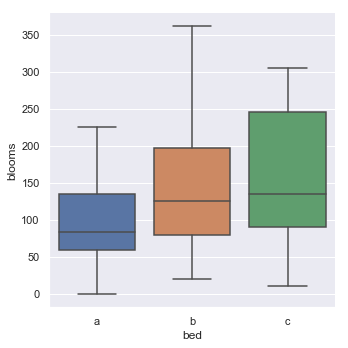

In [394]:
sns.catplot(x='bed', y='blooms', data=d_tulips, kind='box')s

this seems to confirm this: bed a has lowest mean, with lowest spread around it

### 7H2.

comparing to m_7_9, which is the same model minus the terms for bed

In [398]:
therapy.compare([m_7_h1, m_7_9])

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m_7_h1,289.56,5.66,0,0.74,6.24,0,1
m_7_9,293.58,4.46,4.03,0.26,6.87,5.18,1


New model wins out, gets 74\% of weight. Explain this in light of posterior distribution of bed coefficients: bed and bloom have a relationship, where on average less growth is expected in bed a, with minor differences between beds b and c. The full posterior interval for these relationships is greater than 0, creating some confidence in their reliability.

As such, knowing about the bed helps the model make a better estimate about bloom size, creating better model fit. Furthermore it gets punished for the added flexiblity of having two more parameters. However, fit advantage seems to outweigh this cost.

### 7H3.

prelude

In [10]:
d = pd.read_csv('./data/rugged.csv', sep=';').set_index('isocode')

# make log version of outcome
d = d.assign(log_gdp=np.log(d.rgdppc_2000))

# drop incomplete cases
dd = d.dropna(subset=['rgdppc_2000'])

In [11]:
dd_full = dd
# SYC = seychelles ISO country code
dd_no_syc = dd.drop(labels='SYC')

(a)

In [12]:
# fith both full and no seychelles models

models = list()
for dataset, name in zip([dd_full, dd_no_syc], ['m_7_h3_full', 'm_7_h3_no_syc']):

    shared = {
        'rugged': theano.shared(dataset['rugged'].values, 'rugged'),
        'cont_africa': theano.shared(dataset['cont_africa'].values, 'cont_africa')
    }

    observed = dataset.log_gdp

    with pm.Model() as model:

        sigma = pm.Uniform('sigma', 0, 10)

        bR = pm.Normal('bR', 0, 1)
        bA = pm.Normal('bA', 0, 1)
        bAR = pm.Normal('bAR', 0, 1)

        a = pm.Normal('a', 8, 100)

        mu = pm.Deterministic('mu', a + bR * shared['rugged'] + bAR * shared['rugged'] * shared['cont_africa'] + bA * shared['cont_africa'])
        log_gdp = pm.Normal('log_gdp', mu, sigma, observed=observed)

    m = therapy.Model(model, shared, name)
    m.fit(dataset)
    
    models.append(m)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bAR, bA, bR, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:06<00:00, 323.21draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bAR, bA, bR, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 559.77draws/s]


In [13]:
m_7_h3_full, m_7_h3_no_syc = models

In [14]:
therapy.precis(m_7_h3_full)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
bR,-0.184354,0.077317,0.003433,-0.306153,-0.062063,436.531020,1.002251
bA,-1.840406,0.216521,0.008535,-2.213645,-1.521091,590.032152,0.999793
bAR,0.346899,0.129463,0.005242,0.125058,0.537755,523.519512,0.999054
a,9.181393,0.138729,0.006113,8.977511,9.416511,415.687692,1.002199
sigma,0.950409,0.054213,0.001587,0.857193,1.028305,1058.842445,0.999008


In [15]:
therapy.precis(m_7_h3_no_syc)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
bR,-0.182045,0.074231,0.003519,-0.297199,-0.067437,438.743051,0.999183
bA,-1.772755,0.218458,0.009782,-2.144835,-1.426248,503.569238,0.998999
bAR,0.245582,0.138416,0.005907,0.027353,0.459546,558.364176,0.999637
a,9.176524,0.133346,0.006289,8.972435,9.376902,396.258054,0.999080
sigma,0.943726,0.051932,0.001750,0.852335,1.022089,925.042665,1.000141


Observation: interaction seems to be lower in data without SYC (mean: 0.25) as compared to with SYC (mean: 0.35). plot to understand better. So effect of ruggedness still seems to be dependant upon continent but less so.

(b)

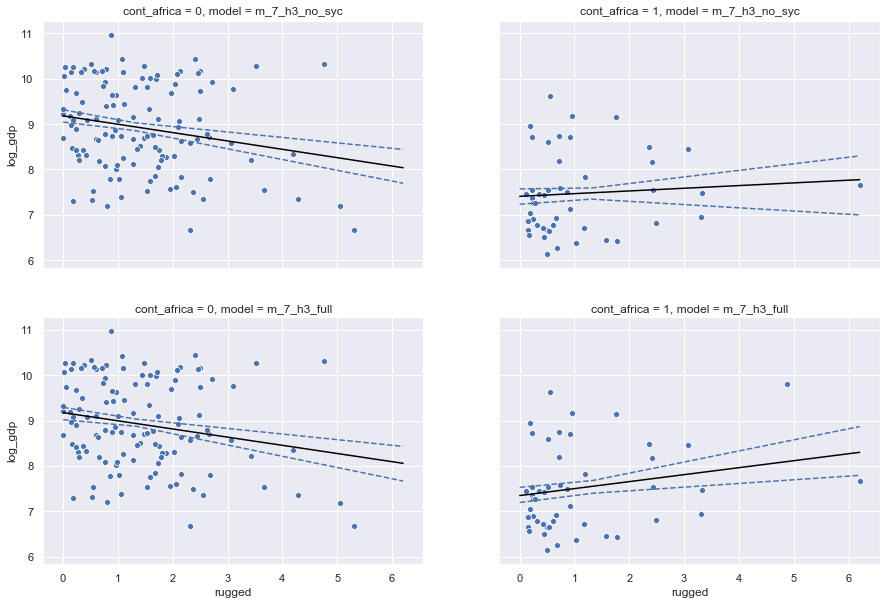

In [84]:
models_and_data = [(m_7_h3_no_syc, dd_no_syc), (m_7_h3_full, dd_full)]
cont_africa_vals = [0, 1]
combinations = itertools.product(models_and_data, cont_africa_vals)

fig, ax_array = plt.subplots(len(models_and_data), len(cont_africa_vals), sharex=True, sharey=True, figsize=(15, 10))

for ((model, d), cont_africa), ax in zip(combinations, ax_array.ravel()):
    sns.scatterplot(x='rugged', y='log_gdp', data=d[d.cont_africa == cont_africa], ax=ax)

    X = pd.DataFrame({'cont_africa': cont_africa, 'rugged': [d.rugged.min(), d.rugged.mean(), d.rugged.max()]})
    preds = model.predict(X, [model.model.mu])
    Xy = X.join(preds)
    
    # how could i do this with seaborn?
    ax.plot('rugged', 'mu_mean', 'black', data=Xy)
    ax.plot('rugged', 'mu_hpd_lower', 'b--', data=Xy)
    ax.plot('rugged', 'mu_hpd_upper', 'b--', data=Xy)

    ax.set_title('cont_africa = {}, model = {}'.format(cont_africa, model.name))

Observation:

Slope still changes between African and non-African nations, indicating that the impact of ruggedness is still impacted by this factor. However, in the model without SYC the slope is less steep for African nations, closer to the one for non-African ones. As such, the impact of being an African nation on the effect of ruggedness on log GDP seems to be lessened when excluding SYC.

(c)

In [29]:
name = 'm_7_h3_c_1'

dataset = dd_no_syc

shared = {
    'rugged': theano.shared(dataset['rugged'].values, 'rugged'),
    'cont_africa': theano.shared(dataset['cont_africa'].values, 'cont_africa')
}

observed = dataset.log_gdp

with pm.Model() as model:

    sigma = pm.Uniform('sigma', 0, 10)

    bR = pm.Normal('bR', 0, 1)
    bA = pm.Normal('bA', 0, 1)
    bAR = pm.Normal('bAR', 0, 1)

    a = pm.Normal('a', 8, 100)

    mu = pm.Deterministic('mu', a + bR * shared['rugged'])
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=observed)

m_7_h3_c_1 = therapy.Model(model, shared, name)
m_7_h3_c_1.fit(dataset)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bAR, bA, bR, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 590.34draws/s]
The acceptance probability does not match the target. It is 0.8797781243075424, but should be close to 0.8. Try to increase the number of tuning steps.


In [28]:
name = 'm_7_h3_c_2'

dataset = dd_no_syc

shared = {
    'rugged': theano.shared(dataset['rugged'].values, 'rugged'),
    'cont_africa': theano.shared(dataset['cont_africa'].values, 'cont_africa')
}

observed = dataset.log_gdp

with pm.Model() as model:

    sigma = pm.Uniform('sigma', 0, 10)

    bR = pm.Normal('bR', 0, 1)
    bA = pm.Normal('bA', 0, 1)
    bAR = pm.Normal('bAR', 0, 1)

    a = pm.Normal('a', 8, 100)

    mu = pm.Deterministic('mu', a + bR * shared['rugged'] + bA * shared['cont_africa'])
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=observed)

m_7_h3_c_2 = therapy.Model(model, shared, name)
m_7_h3_c_2.fit(dataset)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bAR, bA, bR, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 560.14draws/s]


In [27]:
name = 'm_7_h3_c_3'

dataset = dd_no_syc

shared = {
    'rugged': theano.shared(dataset['rugged'].values, 'rugged'),
    'cont_africa': theano.shared(dataset['cont_africa'].values, 'cont_africa')
}

observed = dataset.log_gdp

with pm.Model() as model:

    sigma = pm.Uniform('sigma', 0, 10)

    bR = pm.Normal('bR', 0, 1)
    bA = pm.Normal('bA', 0, 1)
    bAR = pm.Normal('bAR', 0, 1)

    a = pm.Normal('a', 8, 100)

    mu = pm.Deterministic('mu', a + bR * shared['rugged'] + bAR * shared['rugged'] * shared['cont_africa'] + bA * shared['cont_africa'])
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=observed)

m_7_h3_c_3 = therapy.Model(model, shared, name)
m_7_h3_c_3.fit(dataset)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bAR, bA, bR, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 589.12draws/s]


In [32]:
compare_df = therapy.compare([m_7_h3_c_1, m_7_h3_c_2, m_7_h3_c_3])

compare_df

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m_7_h3_c_3,463.12,4.35,0,0.73,14.64,0,1
m_7_h3_c_2,465.67,3.61,2.55,0.27,14.14,3.17,0
m_7_h3_c_1,536.18,2.61,73.06,0,13,14.62,0


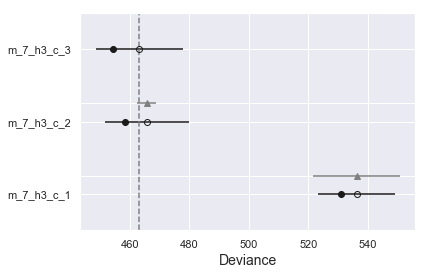

In [33]:
pm.compareplot(compare_df)

In [35]:
models = [m_7_h3_c_1, m_7_h3_c_2, m_7_h3_c_3]

In [37]:
weights = [compare_df.loc[m.name, 'weight'] for m in models]
weights

[0.0, 0.27, 0.73]

In [ ]:
n_total_samples = 10000

In [63]:
mu_samples_with_model = therapy.sample_mu_ensemble_ppc(models, weights, n_total_samples)

100%|██████████| 7300/7300 [00:01<00:00, 6146.04it/s]


In [64]:
mu_samples_with_model.model.value_counts() / len(mu_samples_with_model)

m_7_h3_c_3    0.73
m_7_h3_c_2    0.27
Name: model, dtype: float64

In [65]:
mu_samples = mu_samples_with_model.drop('model', axis=1)

In [79]:
hpd = pm.hpd(mu_samples.values, alpha=0.03)

In [83]:
y = (
    pd.DataFrame([])
    .assign(
        mu_mean = mu_samples.mean(),
        mu_hpd_lower = hpd[:, 0],
        mu_hpd_upper = hpd[:, 1]
    )
    .set_index(dd_no_syc.index)
)

y.head()

,mu_mean,mu_hpd_lower,mu_hpd_upper
isocode,,,
AGO,7.467184,7.192539,7.767192
ALB,8.595254,8.208399,8.998141
ARE,9.027643,8.802462,9.238276
ARG,9.026667,8.802539,9.235679
ARM,8.715471,8.414714,8.994696


In [102]:
Xy = (
    dd_no_syc
    .join(y)
    .sort_values('rugged')
)

Xy.head()

,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,lon,...,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent,log_gdp,mu_mean,mu_hpd_lower,mu_hpd_upper
isocode,,,,,,,,,,,,,,,,,,,,,
DMA,212,Dominica,0.003,0.008,0.005,0.001,0.0,75.0,15.427,-61.356,...,NaN,NaN,NaN,NaN,824.0,NaN,8.688069,9.152252,8.844361,9.457606
KNA,659,Saint Kitts and Nevis,0.006,0.010,0.012,0.003,0.0,26.0,17.274,-62.704,...,NaN,NaN,NaN,NaN,743.0,NaN,9.325872,9.151764,8.844142,9.456730
ATG,28,Antigua and Barbuda,0.006,0.003,0.012,0.003,0.0,44.0,17.271,-61.800,...,NaN,NaN,NaN,NaN,747.0,NaN,9.212541,9.151764,8.844142,9.456730
SGP,702,Singapore,0.016,0.004,0.036,0.005,0.0,67.0,1.361,103.820,...,NaN,NaN,NaN,NaN,49570.0,0.50,10.069494,9.150138,8.843378,9.453811
NLD,528,Netherlands,0.037,0.042,0.108,0.012,0.0,3388.0,52.250,5.621,...,NaN,NaN,NaN,NaN,600000.0,95.95,10.261516,9.146721,8.841774,9.447680


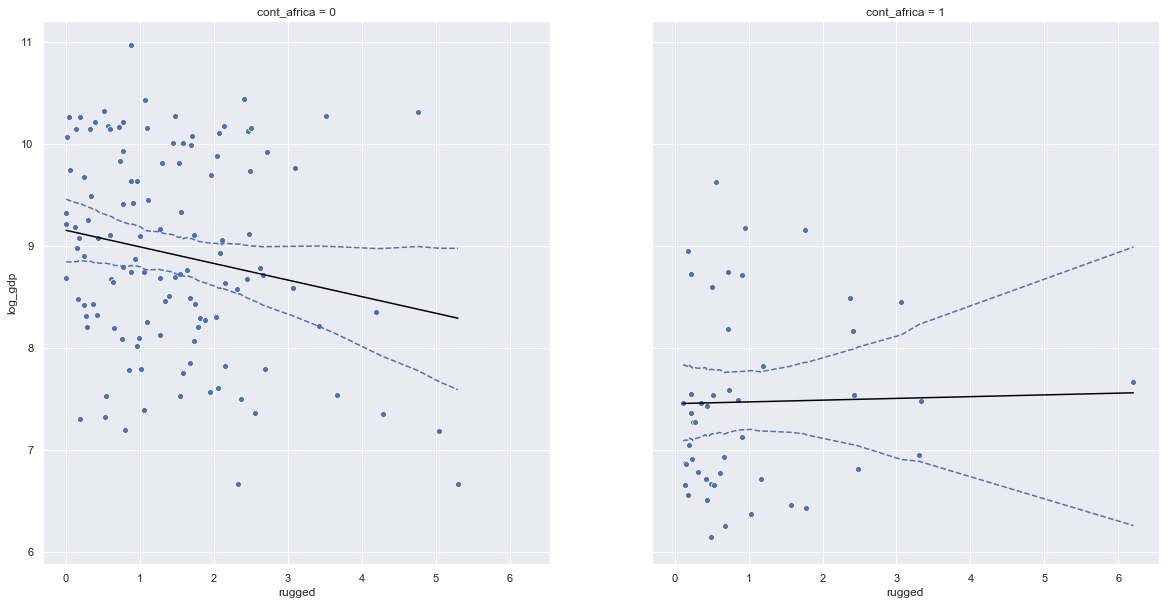

In [112]:
cont_africa_vals = [0, 1]

fig, ax_array = plt.subplots(1, len(cont_africa_vals), sharex=True, sharey=True, figsize=(20, 10))

for cont_africa, ax in zip(cont_africa_vals, ax_array.ravel()):

    Xy_cont = Xy.query('cont_africa == {}'.format(cont_africa))

    sns.scatterplot(x='rugged', y='log_gdp', data=Xy_cont, ax=ax)
    
    ax.plot('rugged', 'mu_mean', 'black', data=Xy_cont)
    ax.plot('rugged', 'mu_hpd_lower', 'b--', data=Xy_cont)
    ax.plot('rugged', 'mu_hpd_upper', 'b--', data=Xy_cont)
    
    ax.set_title('cont_africa = {}'.format(cont_africa))


Observation:

Estimates differe in that they are wider. Also, for cont_africa = 1, effect of ruggedness seems to be even smaller, leading to an even more horizontal line of mean predictions.

Reason:

Wider estimates because said estimates include uncertainty and differences from multiple models instead of just one. In particular, model with both rugged and africa effects combined with model using those effects and in addition the interaction term.

### 7H4

Prelude

In [2]:
nettle_df = (
    pd
    .read_csv('./data/nettle.csv', sep=';')
    .rename(columns = lambda x: x.replace('.', '_'))
    .set_index('country')
    .assign(
        log_lang_per_cap = lambda x: np.log(x.num_lang / x.k_pop),
        log_area = lambda x: np.log(x.area)
    )
)

nettle_df.head()

,num_lang,area,k_pop,num_stations,mean_growing_season,sd_growing_season,log_lang_per_cap,log_area
country,,,,,,,,
Algeria,18,2381741,25660,102,6.60,2.29,-7.262317,14.683342
Angola,42,1246700,10303,50,6.22,1.87,-5.502521,14.036011
Australia,234,7713364,17336,134,6.00,4.17,-4.305219,15.858465
Bangladesh,37,143998,118745,20,7.40,0.73,-8.073816,11.877555
Benin,52,112622,4889,7,7.14,0.99,-4.543499,11.631792


In [3]:
# just standardize everything
nettle_std_df = (nettle_df - nettle_df.mean()) / nettle_df.std()

(a)

In [4]:
with pm.Model() as m:
    # define dataset and shared variables
    data = nettle_std_df
    shared = therapy.create_theano_shared_from_df(data)
    # intercept and coefficients
    pm.Normal('a', data.log_lang_per_cap.mean(), 5)
    pm.Normal('b_log_area', 0, 1)
    pm.Normal('b_mean_growing_season', 0, 1)
    # linear model
    pm.Deterministic(
        'mu', 
        m.a 
        + m.b_log_area * shared['log_area']        
        + m.b_mean_growing_season * shared['mean_growing_season']
    )
    # likelihood
    pm.Uniform('sigma', 0, 10)
    pm.Normal('log_lang_per_capita', m.mu, m.sigma, observed=shared['log_lang_per_cap'])

In [5]:
m_7h4a = therapy.Model(m, shared, 'm_7h4a')

In [6]:
m_7h4a.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_mean_growing_season, b_log_area, a]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 581.97draws/s]


In [7]:
therapy.interesting_summary(m_7h4a)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.002068,0.107783,0.002949,-0.206454,0.208143,1077.811964,1.000521
b_log_area,-0.165169,0.123186,0.003838,-0.398523,0.075460,888.893026,0.999137
b_mean_growing_season,0.295017,0.115987,0.003612,0.078416,0.533169,991.589662,0.999045
sigma,0.949019,0.082441,0.002411,0.813200,1.130523,901.471250,1.002085


Interpretation:

Looks like growing season duration has a consistently positive impact, supporting the hypothesis. Log area has a negative impact which also makes sense, as we are measuring languages per capita and for large areas people are more spread out and would probably interact less, even if there are more people in general. However, that effect is not consistently on one side of 0.

In [8]:
# alternative: use trace property as samples of mu. already exists after fitting

# mus = (
#     pm
#     .trace_to_dataframe(m_7h4a.trace)
#     .filter(like='mu__', axis=1)
# )
# mu_means = mus.mean()
# mu_hpd = pm.hpd(mus.values, 0.03)

# xy = (
#     nettle_std_df
#     .assign(
#         mu_mean = mu_means.values,
#         mu_hpd_lower = mu_hpd[:, 0],
#         mu_hpd_upper = mu_hpd[:, 1],
#         mu_linear_prediction = lambda df: (
#             0.000695
#             + -0.167238 * df.log_area.values
#             + 0.292458 * df.mean_growing_season.values
#         )
#     )
#     .sort_values('mean_growing_season')
# )

100%|██████████| 1000/1000 [00:00<00:00, 1161.95it/s]


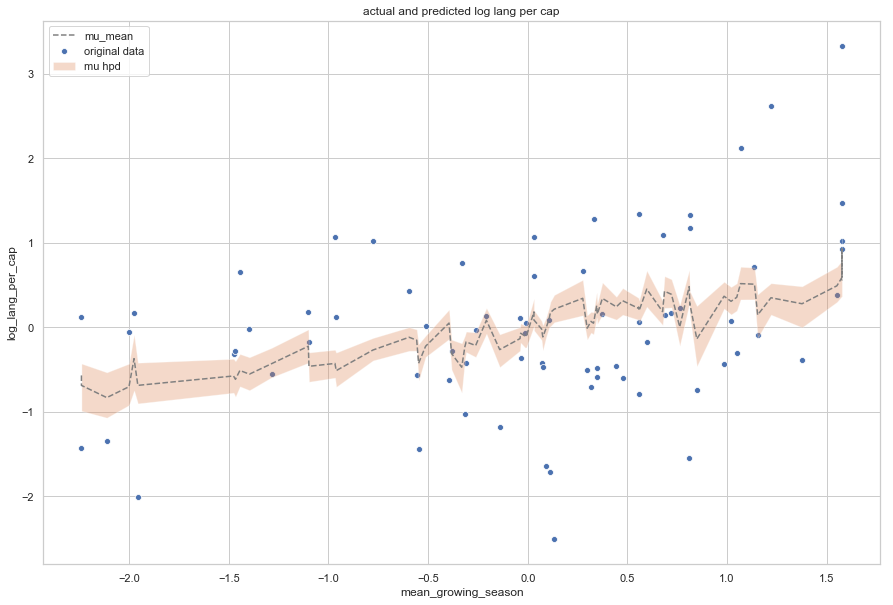

In [9]:
# simple plot: outcome vs mean growing season overlaid on true data

# predict
y = m_7h4a.predict(sample_ppc_kwargs={'var_names': ['mu']})

# join predictions and original data and sort for plotting
xy = (
    pd
    .concat(
        [nettle_std_df, y.set_index(nettle_std_df.index)], 
        axis=1
    )
    .sort_values('mean_growing_season')
)

# plot
ax = sns.scatterplot(x='mean_growing_season', y='log_lang_per_cap', data=xy, label='original data')
ax.plot('mean_growing_season', 'mu_mean', data=xy, label='mu_mean', linestyle='--', color='grey')
ax.fill_between('mean_growing_season', 'mu_hpd_lower', 'mu_hpd_upper', data=xy, alpha=.3, label='mu hpd')

ax.set_title('actual and predicted log lang per cap');
plt.legend();
plt.gcf().set_size_inches(15, 10)

In [10]:
# goal: tryptich plot, fix log area to min/mean/max, plot lang per cap against mean growing season
#
# is this actually useful? can see how straight line of predictions shifts up/down given different values
# for log_area, but hard to see how well it actually fits real data.
# reason: tryptich plot in book is based on categorical variable, easy to find data points where
# real value = fixed value for plot. however, here log_area is continuous, will probably find barely any
# real data points with this exact value

100%|██████████| 1000/1000 [00:00<00:00, 2173.77it/s]


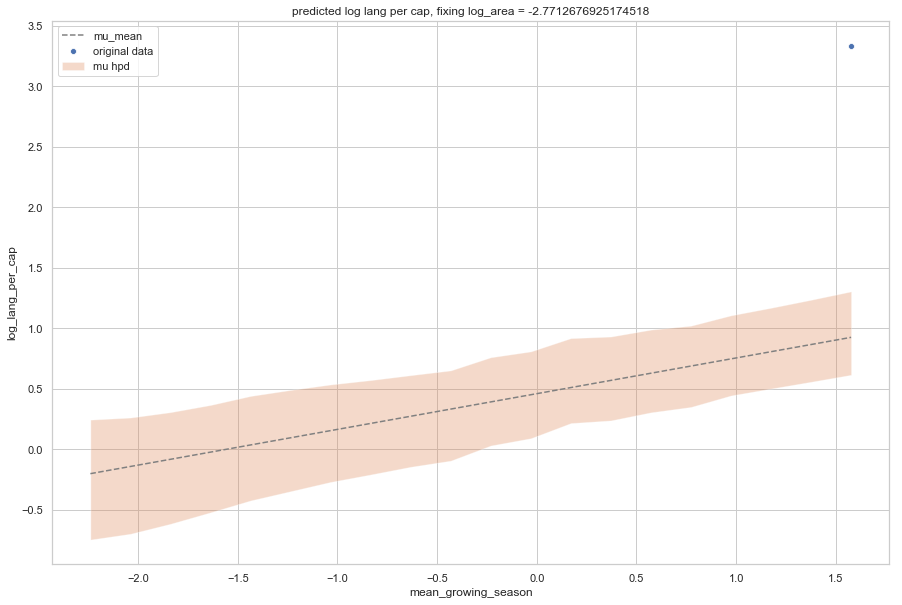

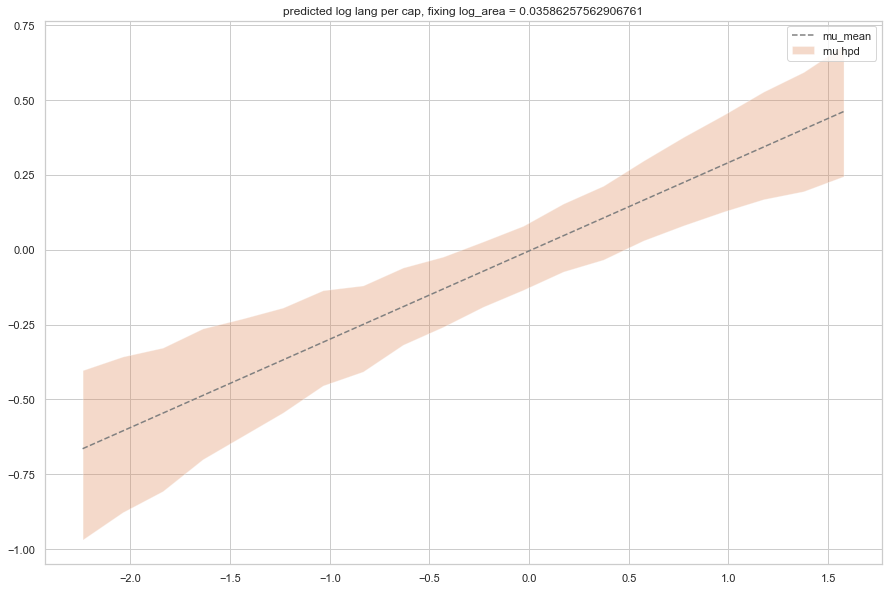

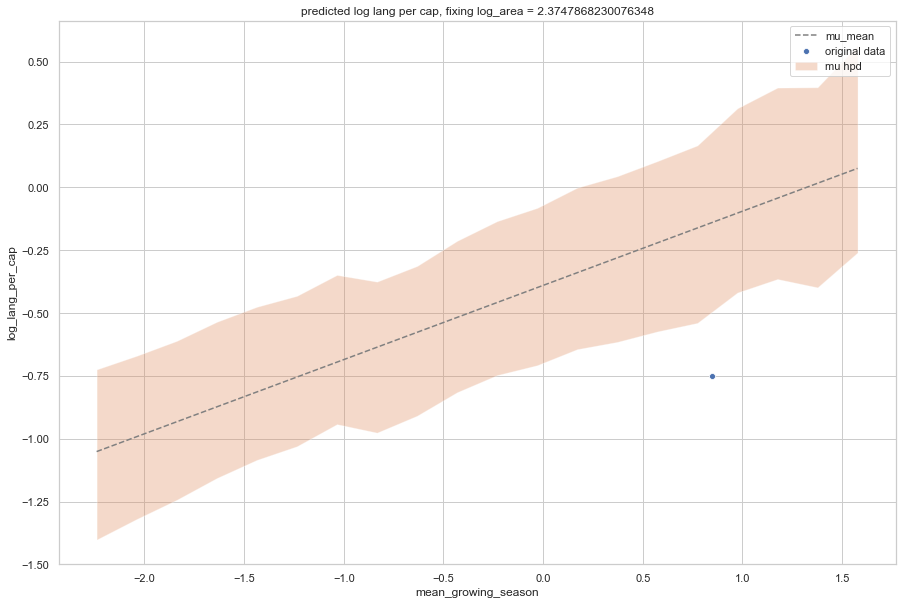

In [11]:
# create synthetic data
log_area_vals = [
    nettle_std_df['log_area'].min(),
    nettle_std_df['log_area'].median(),
    nettle_std_df['log_area'].max()
]

for log_area in log_area_vals[:]:

    pred_x = pd.DataFrame(
        data = {
            'log_area': log_area,
            'mean_growing_season': np.linspace(
                nettle_std_df['mean_growing_season'].min(),
                nettle_std_df['mean_growing_season'].max(),
                20
            )
        }
    )

    predictions = m_7h4a.predict(pred_x, sample_ppc_kwargs={'var_names':['mu']})

    # 'set_index()' necessary in case ix of x-values and ix of predictions does not match
    xy = pd.concat([pred_x, predictions.set_index(pred_x.index)], axis=1)
    xy.head()

    plt.figure()
    ax = plt.gca()
    # how to choose the original data points where log area is reasonably close to current fixed value?
    sns.scatterplot(x='mean_growing_season', y='log_lang_per_cap', data=nettle_std_df.query(f'log_area == {log_area}'), label='original data', ax=ax)
    ax.plot('mean_growing_season', 'mu_mean', data=xy, label='mu_mean', linestyle='--', color='grey')
    ax.fill_between('mean_growing_season', 'mu_hpd_lower', 'mu_hpd_upper', data=xy, alpha=.3, label='mu hpd')

    ax.set_title('predicted log lang per cap, fixing log_area = {}'.format(xy.iloc[0]['log_area']));
    plt.legend();
    plt.gcf().set_size_inches(15, 10)

(b)

In [ ]:
# from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(
#     xy['mean_growing_season'],
#     xy['log_area'],
#     xy['log_lang_per_cap'],
#     alpha=.6,
#     label='original'
# )

# ax.scatter(
#     xy['mean_growing_season'],
#     xy['log_area'],
#     xy['mu_mean'],
#     alpha=.6,
#     label='mu mean'
# )

# ax.scatter(
#     xy['mean_growing_season'],
#     xy['log_area'],
#     xy['mu_linear_prediction'],
#     alpha=.6,
#     label='mu linear prediction'
# )

# mean_growing_season = np.linspace(-5, 5, 20)
# log_area = np.linspace(-5, 5, 20)

# mean_growing_season, log_area = np.meshgrid(mean_growing_season, log_area)

# log_lang_per_cap_mean = (
#     0.000695 
#     + 0.292458 * mean_growing_season
#     + 0.167238 * log_area
# )

# ax.plot_surface(
#     mean_growing_season, 
#     log_area, 
#     log_lang_per_cap_mean, 
#     linewidth=0, 
#     antialiased=False,
#     alpha=.1,
# )

# ax.set_xlabel('mean growing season')
# ax.set_ylabel('log area')
# ax.set_zlabel('log lang per cap')
# ax.legend()




#####################################################################################################
# Question: why do predictions, i.e. 'mu mean' or 'mu linear prediction',
# not align with surface plot?
#
# They should align by this logic:
# surface plot evaluates prediction function at each point in space
# all predictions made by prediction function should have some x, y input pair and
# should result from same formula as surface plot
# thus: predictions should lie on surface
# 
# However, they deviate. Why? Error in plotting code? Misunderstanding logic
# of prediction?
#####################################################################################################s

In [13]:
with pm.Model() as m:
    # define dataset and shared variables
    data = nettle_std_df
    shared = therapy.create_theano_shared_from_df(data)
    # intercept and coefficients
    pm.Normal('a', data.log_lang_per_cap.mean(), 5)
    pm.Normal('b_sd_gs', 0, 1)
    pm.Normal('b_log_area', 0, 1)
    # linear model
    pm.Deterministic(
        'mu', 
        m.a 
        + m.b_log_area * shared['log_area']        
        + m.b_sd_gs * shared['sd_growing_season'] 
    )
    # likelihood
    pm.Uniform('sigma', 0, 10)
    pm.Normal('log_lang_per_capita', m.mu, m.sigma, observed=shared['log_lang_per_cap'])

In [14]:
m_7h4b = therapy.Model(m, shared, 'm_7h4b')

In [15]:
m_7h4b.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_log_area, b_sd_gs, a]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 691.13draws/s]


In [16]:
therapy.interesting_summary(m_7h4b)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,-0.001123,0.113934,0.003708,-0.226285,0.212678,1000.740557,0.999070
b_sd_gs,-0.144809,0.134743,0.004746,-0.402350,0.115615,637.405298,1.001758
b_log_area,-0.199679,0.133887,0.004593,-0.477449,0.058356,791.940821,0.999058
sigma,0.988527,0.086731,0.002769,0.837318,1.168483,909.788325,0.999944


Interpretation:

The mean effect of standard deviation of growing season on languages per capita is negative. However, this is not consistently true, as the HPD ranges from -0.42 to 0.08.

Again, log(area) has a mean negative effect on languages per capita, providing more evidence for the hypothesis that a higher area leads to less interaction but a higher population, thus fewer languages per capita.

100%|██████████| 1000/1000 [00:00<00:00, 1880.92it/s]


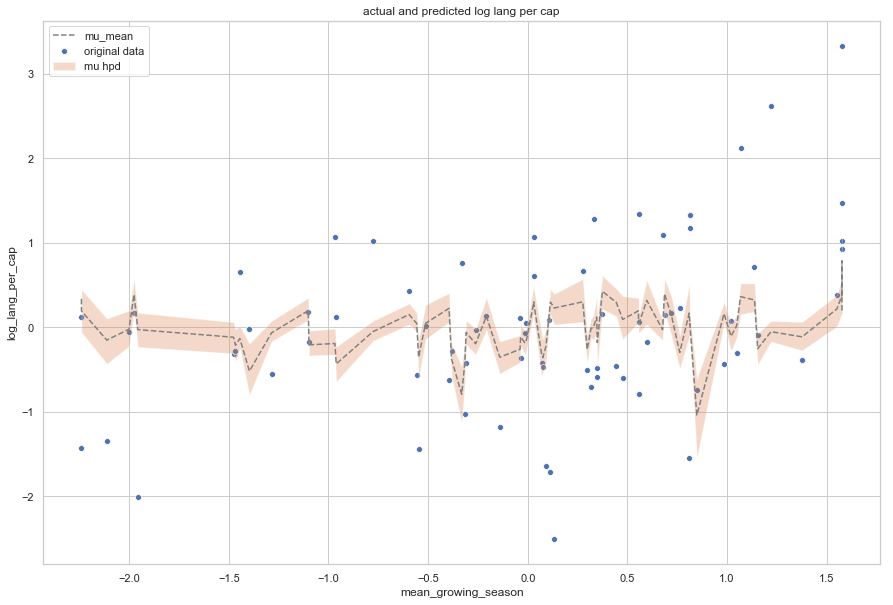

In [17]:
# simple plot: outcome vs mean growing season overlaid on true data

# predict
y = m_7h4b.predict(sample_ppc_kwargs={'var_names': ['mu']})

# join predictions and original data and sort for plotting
xy = (
    pd
    .concat(
        [nettle_std_df, y.set_index(nettle_std_df.index)], 
        axis=1
    )
    .sort_values('mean_growing_season')
)

# plot
ax = sns.scatterplot(x='mean_growing_season', y='log_lang_per_cap', data=xy, label='original data')
ax.plot('mean_growing_season', 'mu_mean', data=xy, label='mu_mean', linestyle='--', color='grey')
ax.fill_between('mean_growing_season', 'mu_hpd_lower', 'mu_hpd_upper', data=xy, alpha=.3, label='mu hpd')

ax.set_title('actual and predicted log lang per cap');
plt.legend();
plt.gcf().set_size_inches(15, 10)

(c)

In [18]:
with pm.Model() as m:
    # define dataset and shared variables
    data = nettle_std_df
    shared = therapy.create_theano_shared_from_df(data)
    # intercept and coefficients
    pm.Normal('a', data.log_lang_per_cap.mean(), 5)
    pm.Normal('b_sd_gs', 0, 1)
    pm.Normal('b_log_area', 0, 1)
    pm.Normal('b_mean_gs', 0, 1)
    pm.Normal('b_mean_gs_x_log_area', 0, 1)
    # linear model
    pm.Deterministic(
        'mu', 
        m.a 
        + m.b_log_area * shared['log_area']        
        + m.b_sd_gs * shared['sd_growing_season'] 
        + m.b_mean_gs * shared['mean_growing_season']
        + m.b_mean_gs_x_log_area * shared['sd_growing_season'] * shared['mean_growing_season']
    )
    # likelihood
    pm.Uniform('sigma', 0, 10)
    pm.Normal('log_lang_per_cap', m.mu, m.sigma, observed=shared['log_lang_per_cap'])

In [19]:
m_7h4c = therapy.Model(m, shared, 'm_7h4c')

In [20]:
m_7h4c.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_mean_gs_x_log_area, b_mean_gs, b_log_area, b_sd_gs, a]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 551.68draws/s]


In [21]:
therapy.interesting_summary(m_7h4c)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.005732,0.100541,0.002800,-0.179210,0.210807,1131.075742,0.999332
b_sd_gs,-0.230434,0.128919,0.004198,-0.467192,0.030518,931.463600,0.999970
b_log_area,-0.008336,0.141694,0.004631,-0.290908,0.258300,1001.388498,0.999317
b_mean_gs,0.231741,0.132820,0.004276,-0.027854,0.492864,884.088650,0.999097
b_mean_gs_x_log_area,-0.240662,0.103922,0.003405,-0.447915,-0.045619,977.205603,1.000404
sigma,0.907326,0.080583,0.002816,0.753437,1.061127,892.408989,1.000417


100%|██████████| 1000/1000 [00:14<00:00, 68.32it/s]


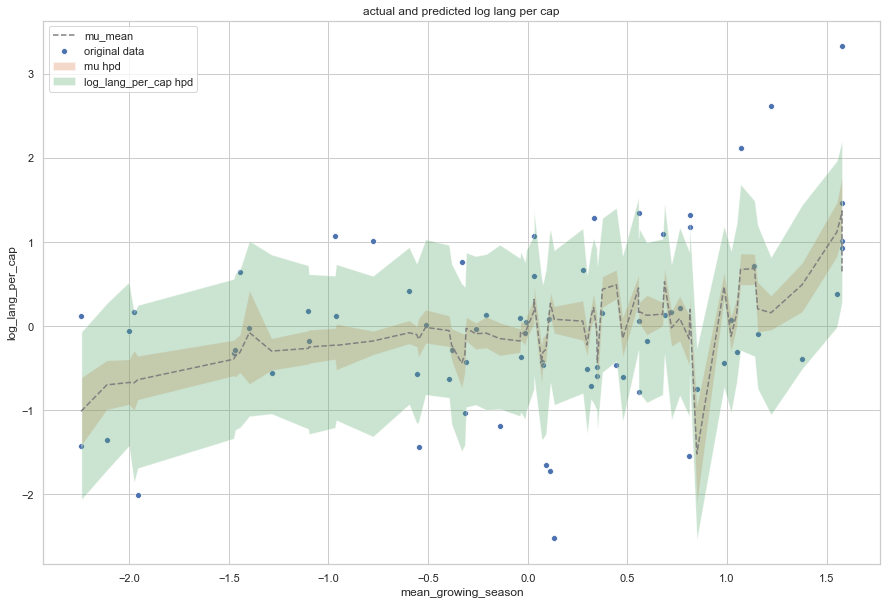

In [22]:
# simple plot: outcome vs mean growing season overlaid on true data

# predict
y = m_7h4c.predict(sample_ppc_kwargs={'var_names': ['mu', 'log_lang_per_cap']})

# join predictions and original data and sort for plotting
xy = (
    pd
    .concat(
        [nettle_std_df, y.set_index(nettle_std_df.index)], 
        axis=1
    )
    .sort_values('mean_growing_season')
)

# plot
ax = sns.scatterplot(x='mean_growing_season', y='log_lang_per_cap', data=xy, label='original data')
ax.plot('mean_growing_season', 'mu_mean', data=xy, label='mu_mean', linestyle='--', color='grey')
ax.fill_between('mean_growing_season', 'mu_hpd_lower', 'mu_hpd_upper', data=xy, alpha=.3, label='mu hpd')
ax.fill_between('mean_growing_season', 'log_lang_per_cap_hpd_lower', 'log_lang_per_cap_hpd_upper', data=xy, alpha=.3, label='log_lang_per_cap hpd')

ax.set_title('actual and predicted log lang per cap');
plt.legend();
plt.gcf().set_size_inches(15, 10)